In [1]:
import time
import numpy as np
from matplotlib import pyplot
from matplotlib import pyplot as plt
import pickle
import pandas as pd

In [41]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
   # plt.fig
    fig = plt.figure(facecolor='white',figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction',color='r')
        plt.legend()
    plt.show();     
def plot_results(train,test,y_hat):
    plt.plot(train,label='Train')
    plt.plot(test,label='Test')
    plt.plot(y_hat,label='forecast')
    plt.legend(loc='best')
    plt.show();
def plot_specific_results(train,test,y_hat):
    plt.plot(test[300:400],label='Test')
    plt.plot(y_hat[300:400],label='forecast')
    plt.legend(loc='best')
    plt.show();

In [3]:
data=pickle.load(open('processed_data.p', "rb" ))

In [4]:
seat_data=data.loc[data['seatName']=='B5_9_1_05']
seat_data=seat_data.sort_values(['Datetime'])
#drop unecessary columns
seat_data=seat_data.drop(['Country','Location','Resource Type','floor','Department','seatName'],axis=1)
seat_data.set_index('Datetime',inplace=True)


### Test 1 : Linear Regression for 1 value

In [5]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.dropna(inplace=True)
    return df

sv_seat_data = timeseries_to_supervised(seat_data['Space'], 1)
sv_seat_data.columns=['x',  'y']
sv_seat_data['x']=sv_seat_data['x'].astype('int64')
display(sv_seat_data.head(3))

,x,y
Datetime,,
2018-03-01 00:10:00,0,0
2018-03-01 00:20:00,0,0
2018-03-01 00:30:00,0,0


In [6]:
train,test=sv_seat_data.iloc[sv_seat_data.index<'2018-03-25'],sv_seat_data.iloc[sv_seat_data.index>='2018-03-25']
y_train,x_train=train['y'],train['x']
y_test,x_test=test['y'],test['x']

In [7]:
from sklearn.linear_model import LinearRegression
regr=LinearRegression()
r_x_train=np.reshape(x_train,(-1,1))
print('r_x_train shape',r_x_train.shape)
model=regr.fit( r_x_train,y_train)
r_x_test=np.reshape(x_test,(-1,1))
y_pred = regr.predict(r_x_test)

r_x_train shape (3455, 1)


C:\Users\ndrs\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


### Test 2 : Polynomial Regression for 1 value

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
regr=LinearRegression()
poly = PolynomialFeatures(4)
r_x_train=np.reshape(x_train,(-1,1))
r_x_test=np.reshape(x_test,(-1,1))
x_transform = poly.fit_transform(r_x_train)
model=regr.fit(x_transform,y_train) 
pred=model.predict(poly.fit_transform(r_x_test))

C:\Users\ndrs\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


In [9]:
pred

array([0.02974751, 0.02974751, 0.02974751, ..., 0.02974751, 0.02974751,
       0.02974751])

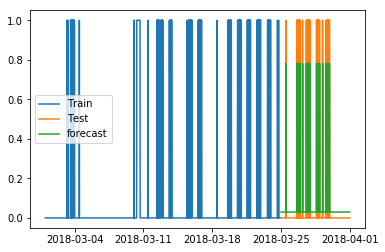

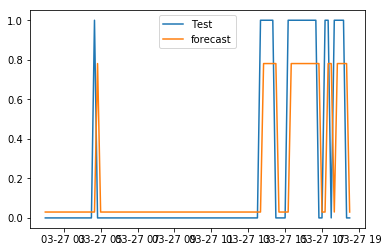

In [12]:
y_hat=test.copy()
y_hat['forecast']=pred
plot_results(y_train,y_test,y_hat['forecast'])
plot_specific_results(y_train,y_test,y_hat['forecast'])

### Test 3 : Linear Regression for 10 steps

In [13]:
seq_len=10
pred_len=10

trial_data=np.array(seat_data['Space'])

sequence_length = seq_len + 1
result = []
for index in range(len(trial_data) - sequence_length):
    result.append(trial_data[index: index + sequence_length])
    
    # shape is (row)4453, (sequence length) 11
result = np.array(result)
row = round(0.85 * result.shape[0])
train = result[:int(row), :]
    # X train keeps all the rows but removes last column, col x row(:-1)
x_train = train[:, :-1]
    # y train keeps the cols with ONLY the values of the missing row (-1)
y_train = train[:, -1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1]
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape,'before reshape')

(3785, 10) (3785,) (668, 10) (668,) before reshape


In [14]:
import statsmodels.api as sm
X2 = sm.add_constant(x_train)
est = sm.OLS(y_train, x_train)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     703.5
Date:                Thu, 26 Apr 2018   Prob (F-statistic):               0.00
Time:                        15:27:48   Log-Likelihood:                 642.09
No. Observations:                3785   AIC:                            -1264.
Df Residuals:                    3775   BIC:                            -1202.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0392      0.016      2.410      0.0

In [15]:
from numpy import newaxis
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    # loop through built prediction batches (test data/pred size)
    for i in range(int(len(data)/prediction_len)):
        #current batch/sequence = test[prediction batch number*prediction length]
        curr_frame = data[i*prediction_len]
        #sample shape = (10,1)
        predicted = []
        # loop through prediction length to build multiple predictions
        #print(curr_frame[newaxis,:].shape)
        for j in range(prediction_len):
            #predict current batch

            
            predicted.append(model.predict(curr_frame[newaxis,:]))
            #predicted.append(np.round(model.predict(curr_frame[newaxis,:]))
            #example result =  [0.011287009]
            #move current frame row by one forward
            curr_frame = curr_frame[1:]
            #insert previous prediction to current frame to predict next sequence
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [16]:
from sklearn.linear_model import LinearRegression
regr=LinearRegression()
r_x_train=x_train
print('r_x_train shape',r_x_train.shape)
model=regr.fit( x_train,y_train)
predictions = predict_sequences_multiple(model,x_test,seq_len,pred_len)


r_x_train shape (3785, 10)


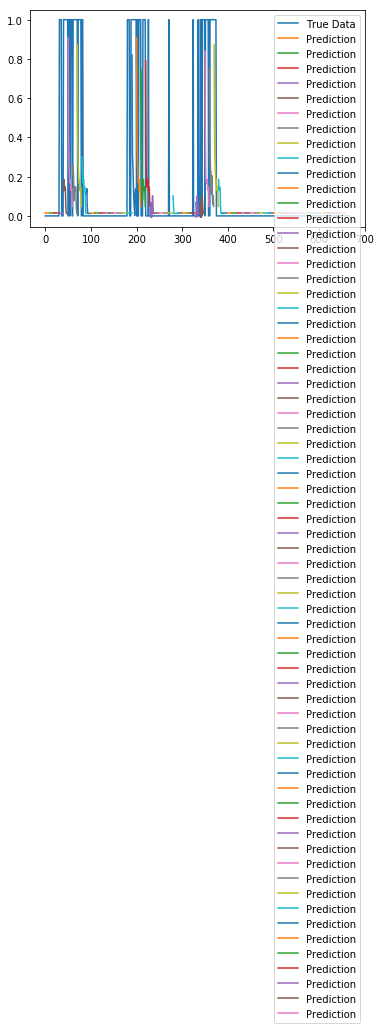

In [18]:
plot_results_multiple(predictions, y_test, seq_len)

### Test 4 : Polynomial Regression for 10 steps

In [27]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.dropna(inplace=True)
    return df

sv_seat_data = timeseries_to_supervised(seat_data['Space'], 1)
sv_seat_data.columns=['x',  'y']
sv_seat_data['x']=sv_seat_data['x'].astype('int64')
display(sv_seat_data.head(3))
train,test=sv_seat_data.iloc[sv_seat_data.index<'2018-03-25'],sv_seat_data.iloc[sv_seat_data.index>='2018-03-25']
y_train,x_train=train['y'],train['x']
y_test,x_test=test['y'],test['x']

,x,y
Datetime,,
2018-03-01 00:10:00,0,0
2018-03-01 00:20:00,0,0
2018-03-01 00:30:00,0,0


In [28]:
from numpy import newaxis
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    # loop through built prediction batches (test data/pred size)
    for i in range(int(len(data)/prediction_len)):
        #current batch/sequence = test[prediction batch number*prediction length]
        curr_frame = data[i*prediction_len]
        #sample shape = (10,1)
        predicted = []
        # loop through prediction length to build multiple predictions
        #print(curr_frame[newaxis,:].shape)
        for j in range(prediction_len):
            #predict current batch
            
            predicted.append(np.round(model.predict(curr_frame[newaxis,:])))
            #predicted.append(np.round(model.predict(curr_frame[newaxis,:]))
            #example result =  [0.011287009]
            #move current frame row by one forward
            curr_frame = curr_frame[1:]
            #insert previous prediction to current frame to predict next sequence
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [62]:
import statsmodels.api as sm
X2 = sm.add_constant(poly.fit_transform(np.array(x_train.values.reshape(-1, 1))))
est = sm.OLS(y_train, poly.fit_transform(np.array(x_train.values.reshape(-1, 1))))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     2253.
Date:                Thu, 26 Apr 2018   Prob (F-statistic):               0.00
Time:                        15:39:41   Log-Likelihood:                 429.89
No. Observations:                3455   AIC:                            -853.8
Df Residuals:                    3452   BIC:                            -835.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0296      0.004      7.634      0.0

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#seq_len=2
#pred_len=3
seq_len=4
pred_len=10
regr = LinearRegression()
poly = PolynomialFeatures(seq_len)

x_train_transform = poly.fit_transform(np.array(x_train.values.reshape(-1, 1)))
model=regr.fit(x_train_transform,y_train)
x_test_transform=poly.fit_transform(x_test.values.reshape(-1, 1))
predictions = predict_sequences_multiple(model,x_test_transform ,seq_len+1,pred_len)

In [59]:
x_train_transform.shape,x_test_transform.shape

((3455, 5), (1008, 5))

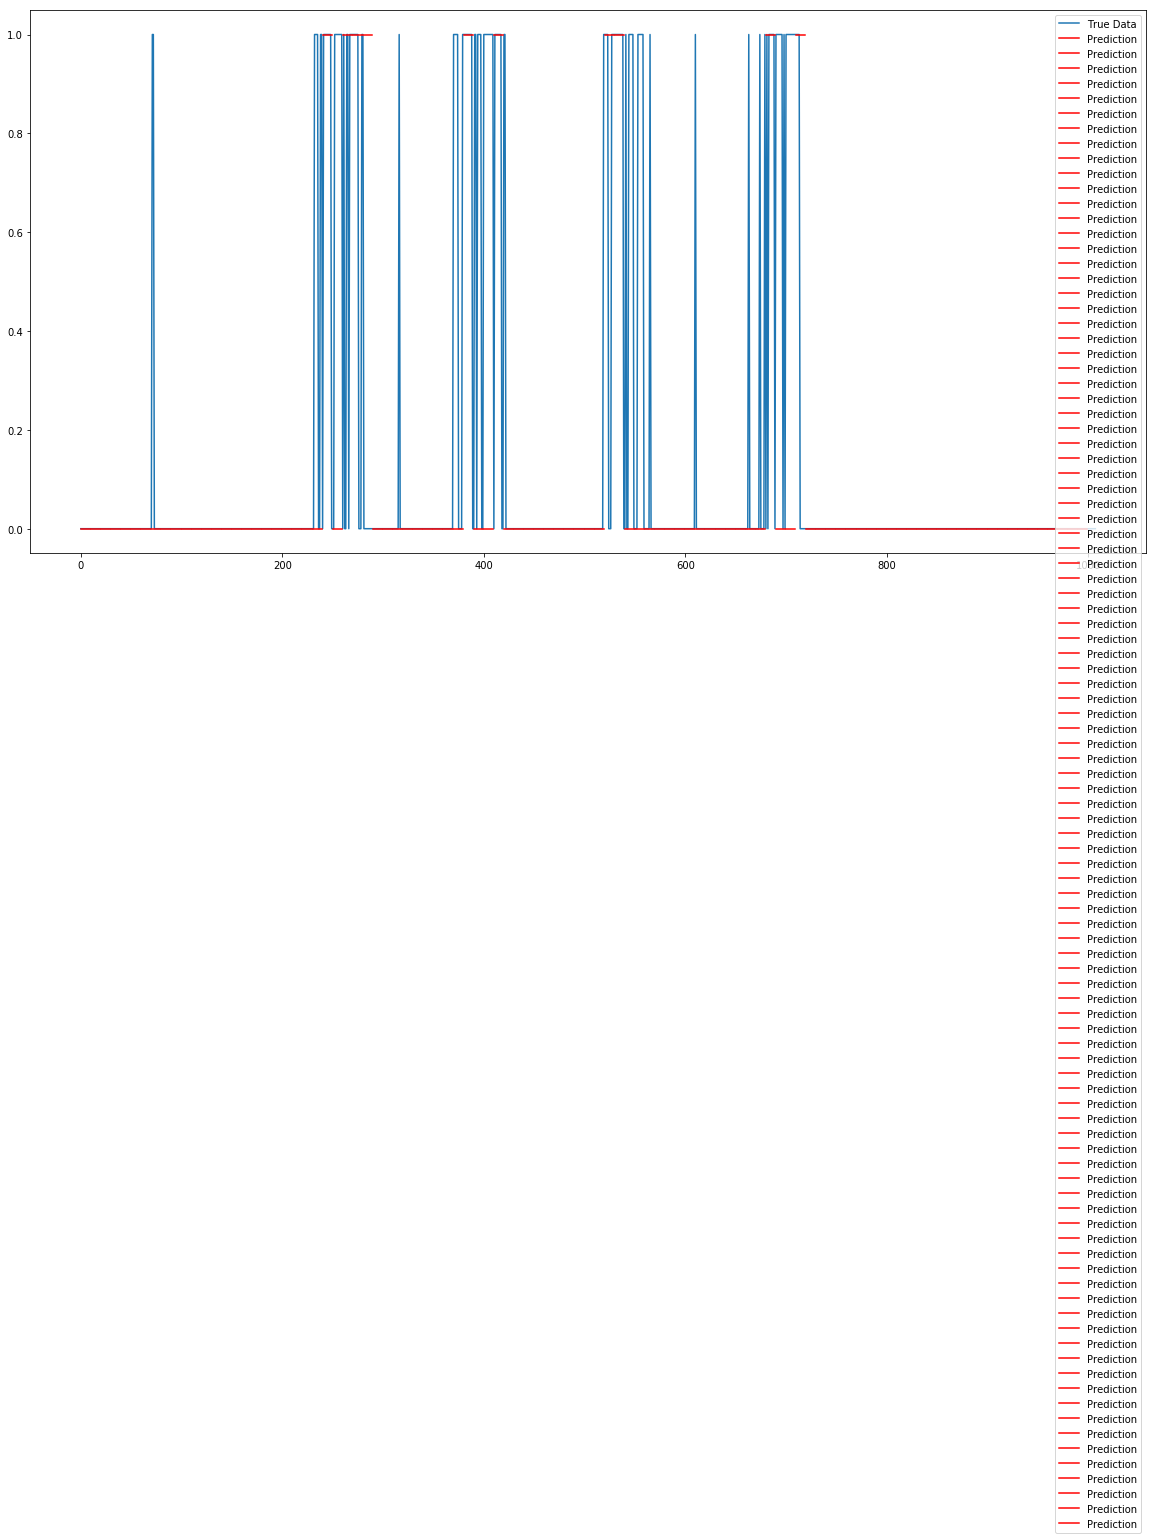

In [60]:
plot_results_multiple(predictions, np.array(y_test), pred_len)